In [27]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binrary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [28]:
import sys
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, PredictionErrorDisplay,  f1_score, confusion_matrix, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p
import utils.utils_processing as pp

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


<Figure size 2000x1000 with 0 Axes>

#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [29]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
#stablelearner = importr('stablelearner')
#ggplot2 = importr('ggplot2')


In [30]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")

try:
    df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)
except:
    pass

print(df_candidates.shape)
df_candidates.tail(2)

(397, 32)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,contaminations_light,contaminations_heavy,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,NaN,130.0,NaN,1,17,2,3,1.0,1,0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,NaN,5.0,33.0,1.0,1,11,2,3,NaN,1,0,736.5


In [31]:
## impl in data_cleaning
#print(df_candidates.floors.describe())
try: 
    df_candidates = df_candidates[df_candidates.floors < 3, : ]
except:
    pass

In [32]:
### TODO impl this cell in data_cleaning

try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass
try:
    df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
    df_candidates = df_candidates.drop(["contaminations_light","contaminations_heavy"], axis=1)
    #df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
except:
    pass


print(df_candidates.shape)
df_candidates.tail(2)

(397, 29)


,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,resilience_govern_careing_increases,shp_registered_capital_euro
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,NaN,130.0,NaN,1,17,2,3,1.0,11047.7
396,NaN,3.0,100.0,0,1,1,0,1,0,0,0,0,1,5,5,5,5,5,5,4,5.0,33.0,1.0,1,11,2,3,NaN,736.5


### Test remove further features

In [33]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro       18.0
resilience_govern_careing_increases    14.0
shp_registered_capital_euro            12.0
bage                                    7.0
hh_monthly_income_cat                   6.0
inundation_duration_h                   2.0
b_area                                  1.0
water_depth_cm                          0.0
contaminations.0                        0.0
electricity_higher_impl                 0.0
shp_avgmonthly_sale_cat                 0.0
shp_employees                           0.0
shp_sector                              0.0
shp_owner                               0.0
flood_experience                        0.0
dtype: float64 2


In [34]:
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


## Fit model 

In [35]:
score_names_for_performance = {
    #"MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    #"RMSE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "neg_MAE": "neg_mean_absolute_error",
    "neg_RMSE": "neg_root_mean_squared_error",
    "MBE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(e.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}


In [217]:
## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
pipelines = ["pipe_en", "pipe_crf", "pipe_xgb"] 
#pipelines = ["pipe_en", "pipe_xgb"]  
#pipelines = ["pipe_en", "pipe_crf"]

eval_set_list = []
models_trained = {}
model_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    model_name = pipe_name.split('_')[1]
    print( f"\nApplying {model_name} on {target}:")
 
    df_candidates_t = df_candidates

    if (target == "Target_relative_contentloss_euro"):
        print(f"Removing {df_candidates_t.loc[df_candidates_t[target]==0.0,:].shape[0]} zero loss records")
        df_candidates_t = df_candidates_t.loc[df_candidates_t[target]!=0.0,:]
        print(f"Keeping {df_candidates_t.shape} damage cases for model training and evaluation")

    ## drop samples where target is nan
    print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]
    
    ## EN: drop samples where any value is nan
    if (model_name == "en") | (model_name == "crf"):
        df_candidates_t.dropna(inplace=True)

    print(
        "Using ", df_candidates_t.shape[0], " records, from those are ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, 
            f" cases with zero-loss or zero-reduction"
    )

    X = df_candidates_t.drop(target, axis=1)  # remove  target from X
    y = df_candidates_t[target]
     
    ## load pipe for non-transfomred model
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

    ## Hyperparmater space to test       
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    ## EN (test with bagging)
    # if model_name == "en":
    #     ## paramter names when bootstrapping mehtod is applied
    #     print("Testing Elastic Net with bagging")
    #     param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}

    if model_name != "crf":

        # ## save evaluation set for later usage in feature importance
        # eval_set =  pd.concat([y, X], axis=1) 
        # eval_set_list.append({pipe_name : eval_set})

        ## define inner and outer cv
        cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=seed)

        ## define inner cv for hyperparameter tuning
        model = RandomizedSearchCV(#GridSearchCV(
            estimator=pipe,
            #param_grid=param_space,
            param_distributions=param_space,
            cv=cv, 
            scoring="neg_mean_absolute_error",
            ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,   
            random_state=seed # only for RandomizedCV needed
        )
 
        ## define outer cv to get generalization performance based on tuned model
        ## run nested cv
        model_cv_result = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
            model, 
            X, y, 
            # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
            scoring=score_names_for_performance,  # Strategy to evaluate the performance of the cross-validated model on the test set.
            cv=cv, 
            return_estimator=True,
            n_jobs=-1

        ) 
        print("outer CV: MAE (std): %.3f (%.3f)"%(model_cv_result["test_neg_MAE"].mean(), np.std(model_cv_result["test_neg_MAE"])))
        models_scores[f"{model_name}"] = model_cv_result ## store scores for FI weighting

        ## outer cv for predictions (n == sample number of entire dataset)
        y_pred = cross_val_predict(
            model,  # estimators from inner cv
            X, 
            cv=10, # KFold without repeats to have for each sample one predicted value 
            method="predict"
        )
        predicted_values[f"{model_name}"] = pd.DataFrame({"y_empirical": y, "y_predicted": y_pred})


        ## TODO  store trained model from inner cv OR store all trained models from inner cv
        models_trained[f"{model_name}"] = model_cv_result["estimator"] #model.best_estimator_


        # ## get coefficient of each predictor from estimators tuned in inner cv 
        # try: 
        #     model_coefs = model.best_estimator_.named_steps['model'].coef_
        #     model_intercept = model.best_estimator_.named_steps['model'].intercept_
        #     print(f"Intercept for {model_name}: {model_intercept}")
        #     model_coef[f"{model_name}"] = pd.DataFrame(zip(X.columns, model_coefs), columns=['features', 'coef']) 
        try:
            model_intercept_dict = {}

            for idx, estimator in enumerate(models_scores[model_name]["estimator"]): ##model_cv_result["estimator"]):
                model_coefs_dict[idx] = estimator.best_estimator_.named_steps['model'].coef_  # coef for each feature in each estimator
                model_intercept_dict[idx] = estimator.best_estimator_.named_steps['model'].intercept_ # one intercept per estimator

            ## calc avg of coefs for each feature
            model_coefs_list = list(model_coefs_dict.values()) 
            mean_model_coefs = {}
            for i in range(len(model_coefs_list[0])):
                row_list = [row[i] for row in model_coefs_list] # get values column-wise
                mean_model_coefs[i] = sum(row_list) / len(row_list) # calculate avgeraged coefficients for each feature

            model_intercept_list = list(model_intercept_dict.values()) 
            mean_model_intercept = np.mean(model_intercept_list)

            ## Calcualte significance of coefficients
            ## https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

            params = np.append(mean_model_intercept, list(mean_model_coefs.values()))
            predictions = models_trained[model_name][3].predict(X)   #TODO replace by mean of all predicted values
            newX = np.append(np.ones((len(X),1)), X, axis=1)
            MSE = (sum((y - predictions)**2))/(len(newX)-len(newX[0]))

            var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
            sd_b = np.sqrt(var_b)
            ts_b = params / sd_b

            p_values = [
                2 * ( 1 - stats.t.cdf(
                    np.abs(i), (len(newX)-len(newX[0]))
                )) 
                for i in ts_b
            ]
            sd_b = np.round(sd_b,3)
            ts_b = np.round(ts_b,3)
            p_values = np.round(p_values,3)
            params = np.round(params,4)

            myDF3 = pd.DataFrame()
            myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3["Probabilities"] = [params, sd_b, ts_b, p_values]
            #model_coef[f"{model_name}"] = pd.DataFrame(zip(X.columns, model_coefs), columns=['features', 'coef']) 
            #myDF3["coefs_bestestimator"] = model.best_estimator_.named_steps['model'].coef_
            #myDF3["intercept_bestestimator"] = model.best_estimator_.named_steps['model'].intercept_
            model_coef[f"{model_name}_selfbuilt"] = myDF3

            from sklearn.feature_selection import f_regression
            f_reg_f_statistics = f_regression(X_en, y_pred) [0]  # f statistics
            f_reg_p_values = f_regression(X_en, y_pred) [1]  # p_values

            model_coef_freg = pd.DataFrame(
                zip(X.columns, f_reg_f_statistics, np.round(f_reg_p_values, 5), 
                    columns=['features', 'f_reg_f_statistics', 'p_value']
                )
            ) 
            model_coef[f"{model_name}_freg"] = model_coef_freg            
        except:
            pass
      

    if model_name == "crf":
        
        # TODO check if cforest normalize X by itself inside nestedcv
        from sklearn.preprocessing import MinMaxScaler
        X = MinMaxScaler().fit_transform(X)
        X = pd.DataFrame(
                X, 
                columns=df_candidates_t.loc[:, df_candidates_t.columns!=target].columns
        )
        base.set_seed(seed)
 
        model = nestedcv.nestcv_train(
            y=y, 
            x=X,
            method="cforest",
            savePredictions="final",
            outer_train_predict=True,
            #tuneGrid=tg, #cv_cores=2,  # leads to random errors
            metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
                # RMSE penalizes large gaps more harshly than MAE
            # maximize=True,
            # #na_action =  stats.na_pass,
            controls = #party.cforest_control( 
                party.cforest_unbiased(
                # only mtry gets tuned by grid
                mtry=2,  # mtry=0 =Bagging without random input var sampling
                ntree = 100,  # didnt improved with 200 or 500 trees
                # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
                #replace = False,
                #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
            ),  # cforest_unbiased= subsampling without replacement repalce=False a
            trControl = caret.trainControl(
                method = "repeatedcv",  # "oob" - then no repeats are needed
                number = 5,   ## = K-folds
                repeats = 5,  #  nbr repeats == number of tried values for mtry
                #savePredictions = "final"  # saves predictions from optimal tuning parameters
            )
        )
        # get outer evaluation metrics for ranking in Feature importance
        crf_rmse  = base.summary(model)[3][0] ,  # RMSE
        crf_r2 = base.summary(model)[3][1],  # R2
        crf_mae = base.summary(model)[3][2],  # MAE
        
        print("Summary CRF", base.summary(model))
        
        ## store best trained model
        models_trained[f"{model_name}"] = model
        
        ## store scores for FI weighting
        #print(score_name, " : %.3f (%.3f)"%(np.mean(model_cv_result), np.std(model_cv_result)))
        # models_scores[f"{model_name}_{score_name}"] = np.mean(model_cv_result) # TODO needs adaption for R package

  
    filename = f'./models_trained/{model_name}_{target}.sav'
    #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
    pickle.dump(model, open(filename, 'wb'))


    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    
    if model_name == "crf":
        ## permimp.permimp() needs refitted model based on best hyperparameters
        best_hyperparameters = fs.r_dataframe_to_pandas(fs.r_best_hyperparamters(model))
        # #cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
        model = party.cforest(Formula(f'{target} ~ .'),  
            data=pd.concat([y.reset_index(), X],
                    axis=1,
                ).drop("index", axis=1),
            #weights=1,
            #control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=300)
            control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
            #control = partykit.ctree_control(mincriterion = 0.8)
        )
        crf_model = model

        importances = permimp.permimp(
            model, 
            threshold = .95,   # # party.varimp()= threshold=.2 , threshold < .5 makes FI too greedy
            conditional=True, 
            progressbar=False
        ) # faster and more stable than party.varimp()
        df_importance = pd.DataFrame(
            #{f"{model_name}_importances" : importances[0]},
            {
                f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
                f"{model_name}_importances_std" : importances[1]
            },
            index=X.columns.to_list(),
        ) 

    else:
        # importances = e.permutation_feature_importance(model, X, y, repeats=5, seed=seed)  
        # # FIXED error: outer cv returns mulitple models 
        # so the average of all models should be used to determine feature importance
        fi_estimators = {}
        ## get feature importances of all estimators from outer cv:
        for idx, estimator in enumerate(model_cv_result["estimator"]):
            fi_estimator = e.permutation_feature_importance(estimator, X, y, repeats=5, seed=seed)  # TODO use only on test set from each outer fold
            fi_estimators[f"{model_name}_{idx}"] = fi_estimator  # FI score and std of each repeat

        ## calculate average of fi scores across estimators
        fi_estimators_list = list(fi_estimators.values()) #list(iter(fi.values()))
        mean_fi_estimators = {}
        for i in range(len(fi_estimators_list[0])):
            row_list = [row[i] for row in fi_estimators_list] # get values column-wise
            mean_fi_estimators[i] = sum(row_list) / len(row_list) # calculate avg of FI score and avg of std

        df_importance = pd.DataFrame(
            {
                f"{model_name}_importances" :  mean_fi_estimators[0],   # mean FI scores across all estimators
                f"{model_name}_importances_std" : mean_fi_estimators[1]  # mean std of Fi scores across all estimators
            },
            index=X.columns.to_list()
        )
        #df_importance.sort_values(f"{model_name}_mean_importances", ascending=False)

    
    df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_importance.iloc[:5].index.to_list())
    df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]
    
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer"
    )

    #models_feature_importances[f"{model_name}_feature_importance"]  = df_importance   # store set of determined features
    
    # df_feature_importances.head(5)
    # ## write selected predictors and response to disk
    # fs.save_selected_features(
    #     X, 
    #     pd.DataFrame(y, columns=[target]), 
    #     df_feature_importances.T.columns, 
    #     filename=f"../../../input_survey_data/selected_predictors/fs_allmodels_{target.split('_')[1]}.xlsx"
    # )

    


Applying en on Target_relative_contentloss_euro:
Removing 191 zero loss records
Keeping (206, 28) damage cases for model training and evaluation
Dropping 73 records from entire dataset due that these values are nan in target variable
Using  110  records, from those are  {0}  cases with zero-loss or zero-reduction


In [ ]:
model_coef[f"{model_name}_freg"]

In [161]:
# from regressors import stats

# # models_scores[model_name]["estimator"][0]
# # stats.coef_pval(ols, X, y)

# # stats.summary()

# # To calculate the p-values of beta coefficients: 
# print("coef_pval:\n", stats.coef_pval(
#     models_scores[model_name]["estimator"][0], X_en, y_en
#     )
# )

# # to print summary table:
# print("\n=========== SUMMARY ===========")
# xlabels = boston.feature_names[which_betas]
# stats.summary(models_scores[model_name]["estimator"][0], X_en, y_en, xlabels)

In [201]:
# ## get coefficient of each predictor from inner cv (with best hyperparameters defined based on lowest MAE)
# model_name = "en"
# model_intercept_dict = {}
# for idx, estimator in enumerate(models_scores[model_name]["estimator"]): ##model_cv_result["estimator"]):
#     model_coefs_dict[idx] = estimator.best_estimator_.named_steps['model'].coef_  # coef for each feature in each estimator
#     model_intercept_dict[idx] = estimator.best_estimator_.named_steps['model'].intercept_ # one intercept per estimator
# model_coefs_dict

# ## calc avg of coefs for each feature and avg intercept of each estimator
# model_coefs_list = list(model_coefs_dict.values()) #list(iter(fi.values()))
# mean_model_coefs = {}
# for i in range(len(model_coefs_list[0])):
#     row_list = [row[i] for row in model_coefs_list] # get values column-wise
#     mean_model_coefs[i] = sum(row_list) / len(row_list) # calculate avg of FI score and avg of std

# model_intercept_list = list(model_intercept_dict.values()) 
# mean_model_intercept = np.mean(model_intercept_list)



# ## Calcualte significance
# ## https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

# params = np.append(mean_model_intercept, list(mean_model_coefs.values()))
# predictions = models_trained["en"][3].predict(X_en)   #TODO replace by mean of all predicted values

# newX = np.append(np.ones((len(X_en),1)), X_en, axis=1)
# MSE = (sum((y_en - predictions)**2))/(len(newX)-len(newX[0]))

# var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
# sd_b = np.sqrt(var_b)
# ts_b = params / sd_b

# p_values = [
#     2 * ( 1 - stats.t.cdf(
#         np.abs(i), (len(newX)-len(newX[0]))
#     )) 
#     for i in ts_b
# ]

# sd_b = np.round(sd_b,3)
# ts_b = np.round(ts_b,3)
# p_values = np.round(p_values,3)
# params = np.round(params,4)

# myDF3 = pd.DataFrame()
# myDF3["Coefficients"], myDF3["Standard Errors"], myDF3["t values"], myDF3["Probabilities"] = [params, sd_b, ts_b, p_values]
# #myDF3["coefs_bestestimator"] = estimator.best_estimator_.named_steps['model'].coef_
# #myDF3["intercept_bestestimator"] = estimator.best_estimator_.named_steps['model'].intercept_

# print(myDF3)

    Coefficients  Standard Errors  t values  Probabilities
0         0.0585            0.249     0.235          0.815
1         0.0004            0.000     1.302          0.196
2         0.0048            0.001     5.828          0.000
3        -0.0022            0.081    -0.027          0.979
4         0.0069            0.019     0.369          0.713
5        -0.0020            0.042    -0.047          0.963
6         0.0005            0.046     0.012          0.991
7        -0.0033            0.056    -0.059          0.953
8        -0.0000            0.050    -0.000          1.000
9         0.0000            0.041     0.000          1.000
10       -0.0006            0.114    -0.005          0.996
11        0.0000            0.094     0.000          1.000
12        0.0044            0.011     0.393          0.695
13        0.0000            0.012     0.000          1.000
14       -0.0066            0.011    -0.614          0.541
15        0.0001            0.012     0.007          0.9

In [207]:
# params #/ sd_b

# #params = np.append(mean_model_intercept, mean_model_coefs)


In [216]:
from sklearn.feature_selection import f_regression
f_regression(X_en, y_pred) [0]  # f statistics
f_reg_p_values = f_regression(X_en, y_pred) [1]  # p_values

print(pd.DataFrame(zip(X.columns, np.round(f_reg_p_values, 5))))#, columns=['features', 'coef']) 


#     Coefficients  Standard Errors  t values  Probabilities
# 0         0.0585            0.249     0.235          0.815
# 1         0.0004            0.000     1.302          0.196
# 2         0.0048            0.001     5.828          0.000
# 3        -0.0022            0.081    -0.027          0.979
# 4         0.0069            0.019     0.369          0.713
# 5        -0.0020            0.042    -0.047          0.963
# 6         0.0005            0.046     0.012          0.991
# 7        -0.0033            0.056    -0.059          0.953
# 8        -0.0000            0.050    -0.000          1.000

                                   0        1
0              inundation_duration_h  0.67285
1                     water_depth_cm  0.61384
2                   contaminations.0  0.84663
3                       flowvelocity  0.94623
4               emergency_measures.1  0.49797
5               emergency_measures.2  0.33710
6               emergency_measures.3  0.00675
7               emergency_measures.4  0.95791
8               emergency_measures.7  0.43598
9               emergency_measures.8  0.13825
10             overall_problem_house  0.58017
11            protect_valuables_impl  0.50919
12               water_barriers_impl  0.02987
13            pumping_equipment_impl  0.73639
14           elevation_building_impl  0.93872
15  resistant_material_building_impl  0.64471
16           electricity_higher_impl  0.94483
17            flood_protections_impl  0.31592
18                  flood_experience  0.06886
19                              bage  0.09704
20                            b_ar

In [20]:
# models_trained[f"{model_name}"] = model_cv_result["estimator"] #model.best_estimator_

model.best_estimator_

# ## get coefficient of each predictor from inner cv (with best hyperparameters defined based on lowest MAE)
# try: 
#     model_coefs = model.best_estimator_.named_steps['model'].coef_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 ElasticNet(alpha=2, l1_ratio=0.75, max_iter=4, random_state=42,
                            tol=1.0))])

In [ ]:
#  fi[f"{model_name}_{idx}"][0] # feature_importances[0].shape  # mean score of FI across all repeats
#  fi[f"{model_name}_{idx}"][1]  #feature_importances[1].shape   # mean of std for FI across all repeats

#mean_fi_estimators["mean_importance_feature_0"]#.shape
#mean_std_fi_estimators
# array([7.58390625e-06, 9.22737704e-05, 2.97421706e-05, 2.34203451e-0
# {'mean_std_importance_feature_0': 7.583906251772939e-06,
#  'mean_std_importance_feature_1': 9.227377044117588e-05,
#  'mean_std_importance_feature_2': 2.9742170601443577e-05,

In [ ]:
#model_intercept
# ?model.best_estimator_.coef

#model.best_estimator_.named_steps['model'].intercept_
#np.transpose(model_coefs)

## Evaluation
Evaluate models based on performance on outer cross-validation 

In [ ]:
## 10 x10 rcloss
#    RMSE   Rsquared        MAE   
#  0.14935    0.09213    0.07177   # mtry=27

# 10  x 5 rcloss
#    RMSE   Rsquared        MAE   
#    0.15245    0.05213    0.07290     # mtry= 14

# 10  x 5 Bred
#    RMSE   Rsquared        MAE   
# 23.7981     0.1602    17.6271    # mtry=18


In [ ]:
#print(models_scores["en"]["test_neg_mean_absolute_percentage_error"].mean())


xgb_model_evaluation = pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
#crf_model_evaluation = pd.DataFrame(models_scores["crf"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).mean(axis=0)
    
# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "crf": [None, 
            None,
            ## rcloss
            round(crf_mae[0], 2), # MAE
            round(crf_rmse[0], 2),  # RMSE
            0.065,  # MBE from .refit()
            round(crf_r2[0], 2),  # R2
            200.0  # SMAPE from .refit() 
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["en", "xgb", "crf"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.loc["test_MAE"] = model_evaluation.loc["test_MAE"].abs()
model_evaluation.loc["test_RMSE"] = model_evaluation.loc["test_RMSE"].abs()


model_evaluation.round(3)

KeyError: 'xgb'

### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect. 

**Note: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#model.best_estimator_.named_steps['model'].

#models_trained["en"].best_estimator_.named_steps['model'].summary()#.tables[1]['P>|t|']
dir(models_trained["en"].best_estimator_)#.named_steps['model'])#.summary2()
#models_trained["en"].estimator.#_final_estimator

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_can_fit_transform',
 '_can_inverse_transform',
 '_can_transform',
 '_check_feature_names',
 '_check_fit_params',
 '_check_n_features',
 '_estimator_type',
 '_final_estimator',
 '_fit',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params',
 '_get_tags',
 '_iter',
 '_log_message',
 '_more_tags',
 '_parameter_constraints',
 '_replace_estimator',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_m

In [ ]:
# #import statsmodels.api as sm

print(model_coef.keys())
print(
    "Regularization type, [0.0:Ridge, 1.0:Lasso] :",
    models_trained["en"].best_params_["model__l1_ratio"]
    ) # L2 === Ridge Regression --> got coefs | L1 ==LASSO , got only zero coefs for all features
print(model_coef["en"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in target unit. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


## summary signe and signifcance is enough : summairzed version

dict_keys(['en'])
Regularization type, [0.0:Ridge, 1.0:Lasso] : 0.75
                            features       coef
3                       flowvelocity  12.723576
20                            b_area  10.400861
19                              bage  -8.618936
8               emergency_measures.7   8.375504
15  resistant_material_building_impl  -7.343459
10             overall_problem_house   6.494270
1                     water_depth_cm   5.957759
28            shp_content_value_euro   5.591028
25           shp_avgmonthly_sale_cat   5.366119
22                         shp_owner   5.041185


#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])

25

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])
coefs = pd.DataFrame(
    # [est[-1].best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]]
    [est.best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]], columns=X.columns
)


In [ ]:
#coefs.mean(axis=0)

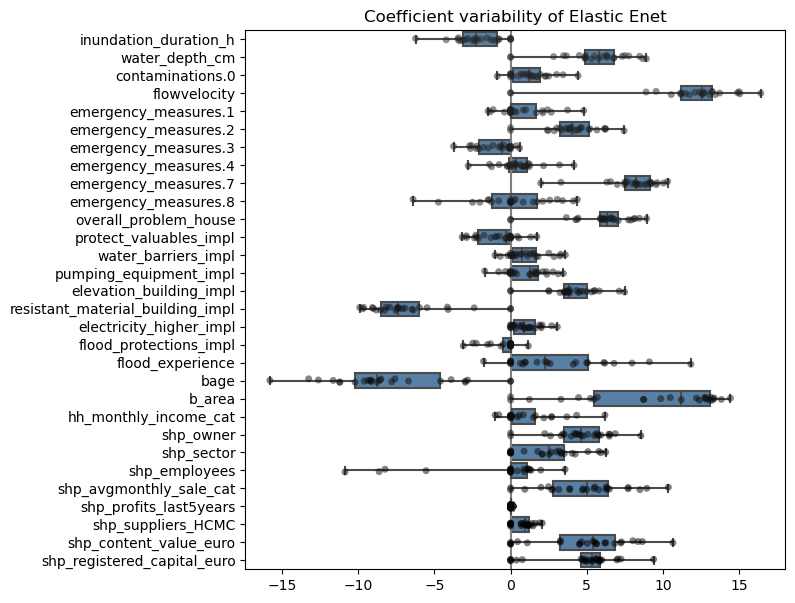

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="steelblue", saturation=0.7, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability of Elastic Enet")
plt.subplots_adjust(left=0.3)



--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

### Feature Importances 


#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [ ]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


        en_importances  xgb_importances
b_area        1.606546         2.131954
bage          1.968858        10.000000


In [ ]:
# np.abs(models_scores["xgb"]["test_neg_MAE"].mean())
# crf_mae

,en_mean_importances,en_meand_importances_std
inundation_duration_h,-1.990839e-06,0.000008
water_depth_cm,2.494220e-04,0.000092
contaminations.0,2.426944e-05,0.000030
flowvelocity,4.122404e-04,0.000234
emergency_measures.1,-8.181940e-05,0.000028
emergency_measures.2,4.421833e-05,0.000063
emergency_measures.3,-1.756640e-04,0.000060
emergency_measures.4,-3.854931e-06,0.000039
emergency_measures.7,0.000000e+00,0.000000
emergency_measures.8,2.842546e-06,0.000002


In [ ]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores =  crf_mae # outer MAE of CRF, 0.0729= MAE

for m in ["xgb", "en"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_neg_MAE"].mean())
df_feature_importances["crf_importances_weighted"]  = df_feature_importances["crf_importances"] / crf_mae #np.abs(models_scores["en_neg_mean_absolute_error"])       # weigth better models more

## TODO add mean score for CRF
df_feature_importances.head(2)


NameError: name 'crf_mae' is not defined

In [ ]:
## overall FI scores
df_feature_importances["mean_all_importances_weighted"] = df_feature_importances[["xgb_importances_weighted","en_importances_weighted", "crf_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["mean_all_importances_weighted"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("mean_all_importances_weighted", ascending=False)[:10]#.describe()

### TODO clarify/read if xgb_importances_weighted	en_importances_weighted needs to be scaled again back to [0,10]
## ranking is not needed

## get median across all importance scores of each feature
#df_feature_importances_ranking["overall_importance"] = df_feature_importances_ranking.median(axis=1)



KeyError: "None of [Index(['xgb_importances_weighted', 'en_importances_weighted',\n       'crf_importances_weighted'],\n      dtype='object')] are in the [columns]"

In [ ]:
## save to disk
df_feature_importances.to_excel(
    f"../../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
df_feature_importances.describe()

## the best model has the highest weighted feature importance value

,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances
count,18.000000,23.000000,27.000000,27.000000,23.000000,18.000000,27.000000
mean,1.324339,1.647409,2.079156,30.275571,19.925867,18.166710,25.507708
std,2.981405,2.875764,2.597945,37.829910,34.783166,40.897621,32.052596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135708
25%,0.002540,0.000000,0.154568,2.250731,0.000000,0.034840,1.290195
50%,0.019935,0.085560,1.151883,16.773110,1.034873,0.273460,11.587368
75%,0.380230,2.094647,2.955931,43.042711,25.335332,5.215831,44.604371
max,10.000000,10.000000,10.000000,145.614730,120.952766,137.175667,145.614730


In [ ]:
#df_feature_importances[["xgb_importances_weighted", "en_importances_weighted"]]
#df_feature_importances.melt(value_vars=["xgb_importances_weighted", "en_importances_weighted"], var_name='model', value_name='importances_weighted')

df_feature_importances.head(5)

shp_avgmonthly_sale_cat	5.475067e-04	0.000123
flowvelocity	4.122404e-04	0.000234
hh_monthly_income_cat	3.392089e-04	0.000101
pumping_equipment_impl	2.812521e-04	0.000179

,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances
b_area,NaN,0.000000,7.172806,104.446620,0.000000,NaN,52.223310
bage,NaN,NaN,10.000000,145.614730,NaN,NaN,145.614730
contaminations.0,0.000000,0.465174,0.046583,0.678314,5.626407,0.00000,2.101574
electricity_higher_impl,0.007425,0.000000,0.159034,2.315772,0.000000,0.10185,0.805874
elevation_building_impl,NaN,0.000000,1.591510,23.174736,0.000000,NaN,11.587368


In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_all_importances_weighted"] = df_feature_importances.fillna(0)["xgb_importances_weighted"] + df_feature_importances.fillna(0)["en_importances_weighted"] + df_feature_importances.fillna(0)["crf_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=True)
df_feature_importances.head(5)

,crf_importances,en_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,overall_importances,sum_importances,mean_all_importances_weighted,sum_all_importances_weighted
electricity_higher_impl,0.007425,0.000000,0.159034,2.315772,0.000000,0.101850,0.805874,2.417623,0.805874,2.417623
shp_owner,NaN,0.035222,0.150101,2.185690,0.426017,NaN,1.305854,2.611708,1.305854,2.611708
emergency_measures.7,0.003707,0.000000,0.179685,2.616483,0.000000,0.050849,0.889111,2.667332,0.889111,2.667332
contaminations.0,0.000000,0.465174,0.046583,0.678314,5.626407,0.000000,2.101574,6.304722,2.101574,6.304722
emergency_measures.4,0.010482,0.030924,0.472280,6.877094,0.374034,0.143792,2.464973,7.394920,2.464973,7.394920


<Figure size 3000x2200 with 0 Axes>

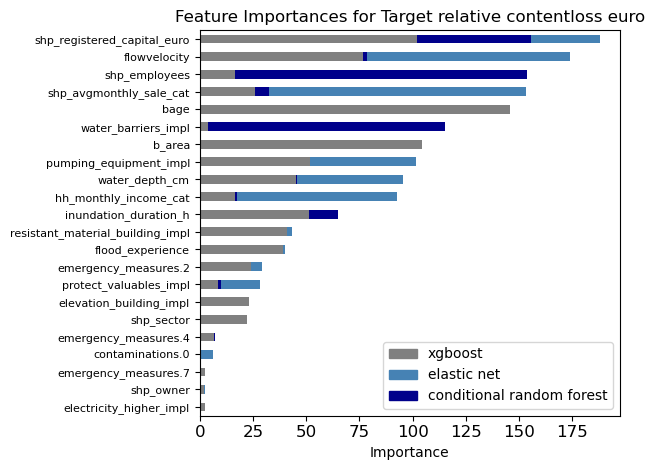

In [ ]:
### drop features which dont reduce the loss
#df_feature_importances = df_feature_importances.loc[df_feature_importances.logreg_importances > 0.001, : ] 
df_feature_importances = df_feature_importances.loc[df_feature_importances.sum_all_importances_weighted > 2, : ] 
#df_feature_importances = df_feature_importances.sort_values("mean_all_importances_weighted", ascending=True)

plt.figure(figsize=(30, 22))
#df_feature_importances.plot.barh(
df_feature_importances[["xgb_importances_weighted", "crf_importances_weighted", "en_importances_weighted",]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"crf_importances_weighted":"darkblue", "en_importances_weighted":"steelblue", "xgb_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="grey", label="xgboost")
middle_bar = mpatches.Patch(color="steelblue", label="elastic net")
bottom_bar = mpatches.Patch(color="darkblue", label="conditional random forest")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=8)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
plt.tight_layout()
#plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:
## sort features by their overall importance (weighted sum across across all features) , first column contains the target
final_feature_names = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=False).index##[:10]

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")

fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx"
)


Dropping 0 records from entire dataset due that these values are nan in target variable
Keeping 324 records and 28 features
total features: 28
selected features: 22
dropped features: 6
selected features: 
['shp_registered_capital_euro', 'flowvelocity', 'shp_employees', 'shp_avgmonthly_sale_cat', 'bage', 'water_barriers_impl', 'b_area', 'pumping_equipment_impl', 'water_depth_cm', 'hh_monthly_income_cat', 'inundation_duration_h', 'resistant_material_building_impl', 'flood_experience', 'emergency_measures.2', 'protect_valuables_impl', 'elevation_building_impl', 'shp_sector', 'emergency_measures.4', 'contaminations.0', 'emergency_measures.7', 'shp_owner', 'electricity_higher_impl']

Saving model to disk: ../../../input_survey_data/final_data_relative_contentloss_tueb.xlsx


In [ ]:
target.split('_',1)[-1].rsplit('_',1)[0]
#df_candidates
df_candidates #pd.DataFrame(y, columns=[target])

 
pd.DataFrame(df_candidates, columns=[target])

,Target_relative_contentloss_euro
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
389,0.0
390,0.0
391,0.0
392,0.0


Optimal number of features

In [ ]:
# models_trained["trained_logreg"].__init__

# # plotting cv results
# plt.figure(figsize=(16,6))

# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
# plt.xlabel('number of features')
# plt.ylabel('r-squared')
# plt.title("Optimal Number of Features")
# plt.legend(['test score', 'train score'], loc='upper left')


In [ ]:
# #print("penalty term: L1=lasso, L2= rigde : " , models_trained["trained_logreg_cv"].penalty)

# # cv results
# cv_results = pd.DataFrame( models_trained["trained_logreg_cv"].cv_results_)
# cv_results


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('model',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           gro...
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=100,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=42, ...))]),
                   param_distributions={'model__booster': ['gblinear'],
                                        'model__max_depth': [1, 2, 3, 5, 7, 10,
                                                             15],
                                        'model__n_estimators': [3, 5, 8, 10, 15,
                                                                20, 30, 50, 100,
                                                                200],
                                        'model__seed': [42]},
                   random_state=42, scoring='neg_mean_absolute_error')

### Partial dependence
PDP shows the marginal effect that one or two features have on the predicted outcome. It shows whether the relationship between the target and a feature is linear, monotonic, or more complex ,as well as the direction of the relationship (see also Coefficients for linear regression tasks). It is introduced by J. H. Friedman and has been widely applied in machine learning modeling.

In [ ]:
## TODO impl PDP for CRF -> convert R vector to python .fit() object .e.g pickle .sav --> relaod as python obj
# models_trained["crf"]#.keys()

e1071 = importr("e1071")

MODEL_SAVE_PATH = "crf_model"
#DEP_LIBS = base.c("e1071")
DEP_LIBS = base.c("party")


# save model
model_rds_path = base.paste(MODEL_SAVE_PATH, ".rds", sep='')
base.saveRDS(models_trained["crf"], model_rds_path)

# save dependency list
model_dep_path = base.paste(MODEL_SAVE_PATH, ".dep", sep='')
file_conn = base.file(model_dep_path)
base.writeLines(DEP_LIBS, file_conn)
base.close(file_conn)

0


In [ ]:
pmml = importr("pmml")

In [ ]:
models_trained["crf"].fit()

AttributeError: 'ListVector' object has no attribute 'fit'

In [ ]:
# Export to PMML:
pmod = pmml.pmml(models_trained["crf"])

# Save to an external file:
pmml.save_pmml(pmod, "crf_model.pmml")


R[write to console]: Error in UseMethod("pmml") : 
  no applicable method for 'pmml' applied to an object of class "nestcv.train"



RRuntimeError: Error in UseMethod("pmml") : 
  no applicable method for 'pmml' applied to an object of class "nestcv.train"


In [ ]:
from pypmml import Model


In [ ]:
m

NameError: name 'm' is not defined

In [ ]:
m = Model.fromFile('crf_model.rds')
result = mm.predict(X)

PmmlError: ('MalformedInputException', 'Input length = 1')

In [ ]:
# ## Make Python Class which Loads R Model
## https://goddoe.github.io/r/machine%20learning/2017/12/17/how-to-use-r-model-in-python.html

# import rpy2.robjects as robjects
# from rpy2.robjects import numpy2ri
# from rpy2.robjects.packages import importr

# r = robjects.r
# numpy2ri.activate()

# class R2PY_Model(object):
#     """
#     R Model Loader
#     model : R object
#     """

#     def __init__(self):
#         self.model = None

#     def load(self, path):
#         model_rds_path = "{}.rds".format(path)
#         model_dep_path = "{}.dep".format(path)

#         self.model = r.readRDS(model_rds_path)

#         with open(model_dep_path, "rt") as f:
#             model_dep_list = [importr(dep.strip())
#                               for dep in f.readlines()
#                               if dep.strip()!='']

#         return self

#     def predict(self, X):
#         """
#         Perform regression/classification on samples in X.
#         X : array, shape (n_samples, n_features)
#         return pred_probs : array, shape (n_samples, probs)
#         """

#         if self.model is None:
#             raise Exception("There is no Model")
        
#         if type(X) is not np.ndarray:
#             X = np.array(X)

#         #pred = r.predict(self.model, X, probability=True)
#         pred = r.predict(self.model, X, probability=False)
#         #probs = r.attr(pred, "probabilities")
#         #return np.array(probs)

#         return np.array(pred)


In [ ]:
## Load R Model Using rpy2 Wrapper Class and Run Example
#from rpy2_wrapper.model import Model

# Constants
MODEL_PATH = "crf_model"

# Example Input
Xy = np.array([[5.1, 3.5,  1.4, 0.2], # setosa
              [6.1, 2.6,  5.6, 1.4]] ) # virginica

# Example Run
model = R2PY_Model().load(MODEL_PATH) # model_rds_path
# Xy = pd.concat(
#         [y.reset_index(), X],
#         axis=1,
#     ).drop("index", axis=1)
pred = model.predict(Xy)

# Example output
print(pred)

R[write to console]: Error: newdata is missing some predictors



RRuntimeError: Error: newdata is missing some predictors


In [ ]:
?model

Type:        R2PY_Model
String form: <__main__.R2PY_Model object at 0x000001E1EE8C3580>
Docstring:  
R Model Loader
model : R object


In [ ]:
# import rpy2
# import rpy2.robjects as robjects

# robjects.r('''
#     r_pdp <- function(m, df, verbose=FALSE) {
#         partial(
#             m, 
#             train=df,
#             pred.var="flowvelocity",
#             type="auto",
#             plot=FALSE, 
#         )  
#     }
#     ''') #  , plot=FALSE --> to get pdp values as table,
#     # plot=True, rug=True, type="regression",
#     # pred.var=c("water_depth_cm", "flowvelocity"), which.class=TRUE


# # get function outside R
# r_pdp = robjects.globalenv['r_pdp'] 
# crf_pdp = r_pdp(
#     models_trained["crf"], 
#     pd.concat(
#         [y.reset_index(), X],
#         axis=1,
#     ).drop("index", axis=1),
# )
# crf_pdp = fs.r_dataframe_to_pandas(crf_pdp)

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In get_task.default(object) :
R[write to console]: 
 
R[write to console]:  `type` could not be determined; assuming `type = "regression"`



In [ ]:
crf_pdp#[13]  # predictorsname
#crf_pdp[26]


,flowvelocity,yhat
1,0.00,0.063215
2,0.25,0.063215
3,0.50,0.063215
4,0.75,0.064066
5,1.00,0.072542


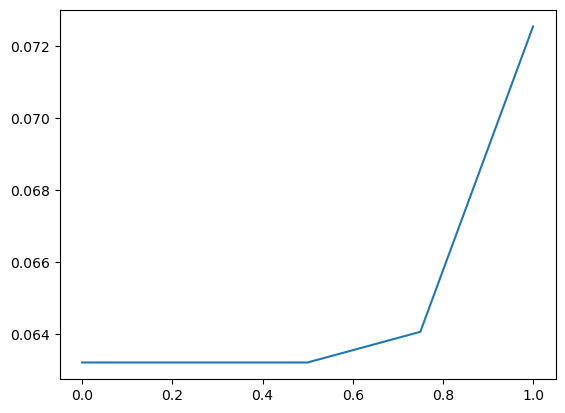

In [ ]:
plt.plot(crf_pdp.iloc[:,0], crf_pdp["yhat"])


In [ ]:
pdp = importr("pdp")

In [ ]:
pdp.partial(
    models_trained["crf"],  
    #train=Formula(f'{target} ~ .'),
    train=pd.concat(
        [y.reset_index(), X],
        axis=1,
    ).drop("index", axis=1),
    pred_var="water_depth_cm" ,    # ERROR couldnt find equivalent expression for "pred.var" in python
    plot=True, rug=True
           )  
#pdp.partialPlot(boston.rf, pred.data=target, x.var = "lstat")

# inundation_duration_h
# train=Formula(f'{target} ~ .'),

Exception ignored from cffi callback <function _callback at 0x0000016B180FAD30>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 


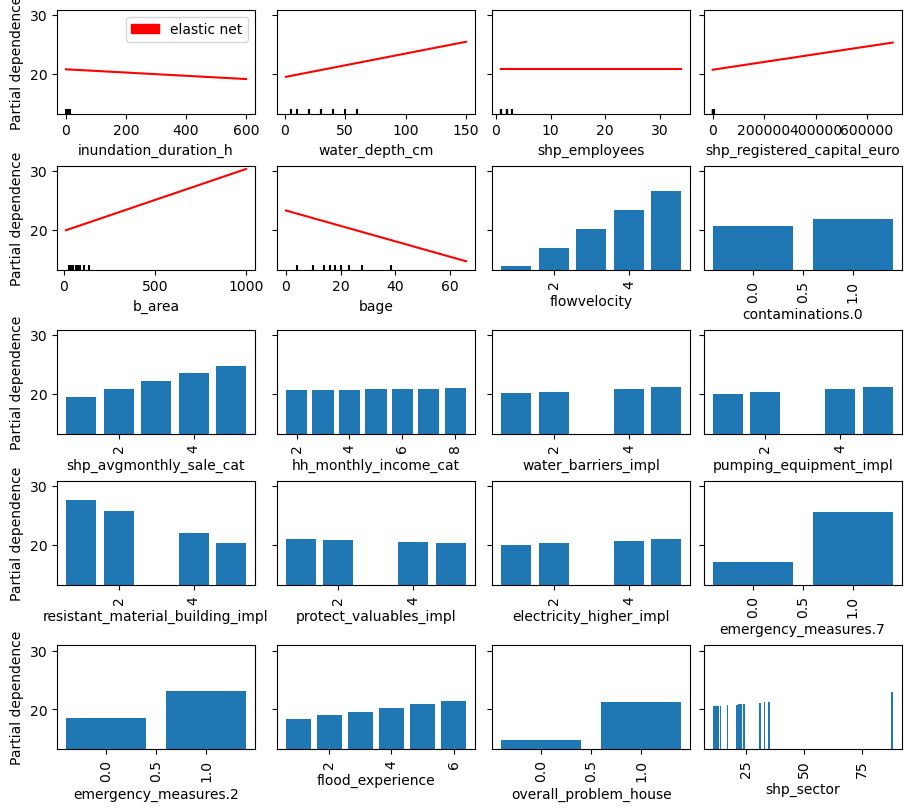

In [ ]:
categorical_features = ["flowvelocity", "contaminations.0", 
                        "shp_avgmonthly_sale_cat", "hh_monthly_income_cat",
                        "water_barriers_impl", "pumping_equipment_impl", 
                        "resistant_material_building_impl", "protect_valuables_impl",
                        "electricity_higher_impl",
                        "emergency_measures.7", "emergency_measures.2", "flood_experience",
                        "overall_problem_house", "shp_sector",
                        ]

features_info = {
    # features of interest (numerical + categorical features)
    "features": ["inundation_duration_h", "water_depth_cm",	
                 "shp_employees","shp_registered_capital_euro", 
                 "b_area", "bage",
                 "flowvelocity", "contaminations.0", 
                        "shp_avgmonthly_sale_cat", "hh_monthly_income_cat",
                        "water_barriers_impl", "pumping_equipment_impl", 
                        "resistant_material_building_impl", "protect_valuables_impl",
                        "electricity_higher_impl",
                        "emergency_measures.7", "emergency_measures.2", "flood_experience",
                        "overall_problem_house", "shp_sector",
                 ],
    # type of partial dependence plot
    "kind": "average",  # PDP
   # "kind": "both",   # PDP with ICE indiv Effectiveness
    #"centered": False, #True,
    # information regarding categorical features
    "categorical_features": categorical_features,
}
common_params = {
    #"subsample": 50,
    #"n_jobs": 2,
   # "grid_resolution": 20,
    "random_state": seed,
}

fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(9, 8), sharex=False, sharey=False, constrained_layout=True)

X_nonan = X.dropna()  
en_pdp = PartialDependenceDisplay.from_estimator(
    models_trained["en"],
    pd.DataFrame(X_nonan, columns=X.columns),  # X_train
    line_kw={"color": "red"},
    **features_info,
    centered=False,
    ax=ax,
    **common_params,
)
# xgb_pdp = PartialDependenceDisplay.from_estimator(
#     models_trained["xgb"],
#     pd.DataFrame(X, columns=X.columns),  # X_train
#     **features_info,
#     centered=False,
#     ax=ax, 
#     line_kw={"color": "green"},
#     **common_params
# )

# crf_pdp = PartialDependenceDisplay.from_estimator(
#     model,
#     #models_trained["trained_crf"],
#     pd.DataFrame(X, columns=X.columns),  # X_train
#     **features_info,
#     ax=ax, 
#     line_kw={"color": "green"},
#     **common_params
# )
# _ = display.figure_.suptitle(
#     (
#         "Partial dependence
#     ),
#     fontsize=16,
# # )
# for i in range(0,5):
#     for j in range(0,4):
#        # ax[i][j].set_ylim(0, 0.3)
#         ax[i][j].set_ylim(0, 1.0)
#plt.tight_layout()
#plt.title("red=Elastic Net, green=XGBoost")
top_bar = mpatches.Patch(color="red", label="elastic net")
#medium_bar = mpatches.Patch(color="green", label="xgboost")
ax[0][0].legend(handles=[top_bar], loc="upper right")
#ax[0][0].legend(handles=[top_bar, medium_bar], loc="upper right")

#plt.show()

# partial_dependence(models_trained["trained_en"], features=[0], X=X, percentiles=(0, 1),
#                     grid_resolution=2) 

# tree_disp.plot(line_kw={"label": "Decision Tree"})
# mlp_disp.plot(
#     line_kw={"label": "Multi-layer Perceptron", "color": "red"}, ax=tree_disp.axes_
# )
#tree_disp.figure_.set_size_inches(10, 6)


- for large buidlings the xgb model predicts higher losses
- higher losses are also linked in the model with slightly less flood experience and higher flowvelocity ,
- model predicts for shops with very low registered capital less losses
- implmenting resistant building material after the flood (nb=4) is linked in the model with higher losses

#### Hetereogenous effects of features -  Individual Conditional Expectation (ICE) 
The partial dependence plot for the average effect of a feature is a global method because it does not focus on specific instances, but on an overall average. The equivalent to a PDP for individual data instances is called individual conditional expectation (ICE) plot (Goldstein et al. 201748). An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. 

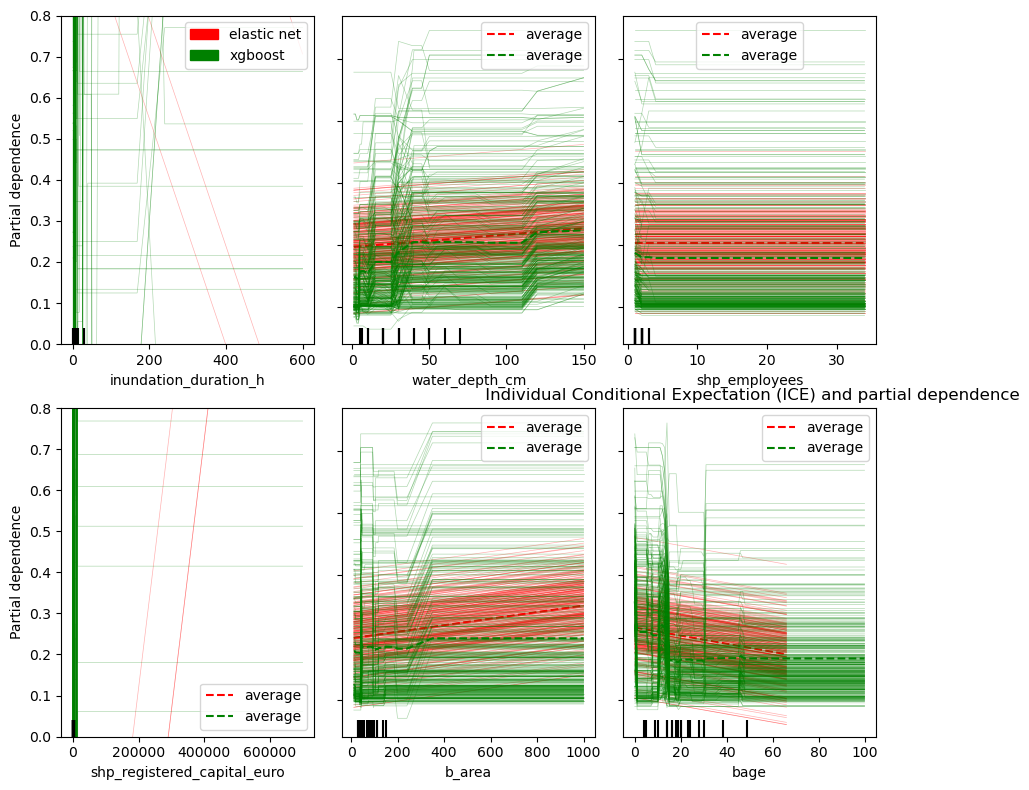

In [ ]:
features_info = {
    # features of interest (numerical + categorical features)
    "features": ["inundation_duration_h", "water_depth_cm",	
                "shp_employees","shp_registered_capital_euro", 
                "b_area", "bage",
                 ],
    # type of partial dependence plot
   "kind": "both",   # PDP with ICE indiv Effectiveness
    #"centered": True,
    # information regarding categorical features
    #"categorical_features": categorical_features,
}
common_params = {
    #"subsample": 50,
    #"n_jobs": 2,
   # "grid_resolution": 20,
    "random_state": seed,
}

_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), sharex=False, sharey=False, constrained_layout=True)

# X_nonan = X.dropna()  
en_pdp = PartialDependenceDisplay.from_estimator(
    models_trained["en"],
    pd.DataFrame(X_nonan, columns=X.columns),  # X_train
    line_kw={"color": "red"},
    **features_info,
    ax=ax,
    **common_params,
)
xgb_pdp = PartialDependenceDisplay.from_estimator(
    models_trained["xgb"],
    pd.DataFrame(X, columns=X.columns),  # X_train
    **features_info,
    ax=ax, 
    line_kw={"color": "green"},
    **common_params
)

for i in range(0,2):
    for j in range(0,1):
        ax[i][j].set_ylim(0, 0.8)
#plt.tight_layout()
#plt.title("red=Elastic Net, green=XGBoost")
top_bar = mpatches.Patch(color="red", label="elastic net")
medium_bar = mpatches.Patch(color="green", label="xgboost")
ax[0][0].legend(handles=[top_bar, medium_bar], loc="upper right")

plt.tight_layout()

# crf_pdp = PartialDependenceDisplay.from_estimator(
#     model,
#     #models_trained["trained_crf"],
#     pd.DataFrame(X, columns=X.columns),  # X_train
#     **features_info,
#     ax=ax, 
#     line_kw={"color": "green"},
#     **common_params
# )
_ = display.figure_.suptitle(
    (
        "Partial dependence"
    ),
    fontsize=16,
)
plt.title(" Individual Conditional Expectation (ICE) and partial dependence")
fig.show()

In [ ]:

# partial_dependence(models_trained["trained_en"], features=[0], X=X, percentiles=(0, 1),
#                     grid_resolution=2) 

# tree_disp.plot(line_kw={"label": "Decision Tree"})
# mlp_disp.plot(
#     line_kw={"label": "Multi-layer Perceptron", "color": "red"}, ax=tree_disp.axes_
# )
#tree_disp.figure_.set_size_inches(10, 6)


#en_pdp = PartialDependenceDisplay.from_estimator(models_trained["trained_en"], X, ["inundation_duration_h"])
# en_disp = PartialDependenceDisplay.from_estimator(
#     models_trained["trained_en"], X, ["age"], ax=tree_disp.axes_, line_kw={"color": "red"}
# )
#xgb_pdp.plot(line_kw={"label": "Decision Tree"})

# print("Computing partial dependence plots...")

# models_partialdependencies.plot(
#     line_kw={"label": "Multi-layer Perceptron", "color": "red"}, ax=xgb_pdp.axes_
# )
# xgb_pdp.figure_.set_size_inches(10, 6)
# xgb_pdp.axes_[0, 0].legend()
# # xgb_pdp.axes_[0, 1].legend()
# plt.show()

# partial_dependence(models_trained["trained_en"], features=[0], X=X, percentiles=(0, 1),
#                     grid_resolution=2) 

# fig = plot_partial_dependence(
#     model, X=X_train, features=features, n_jobs=5, grid_resolution=50#, fig=fig
# ) #, feature_names
# plt.subplots_adjust(top=1.2)
# plt.savefig(outfile, bbox_inches="tight")

In [ ]:
# #def plot_partial_dependencies(model, X_train, outfile):
#     # """
#     # Creates plots for partial dependecies
#     # :param model: Model instance
#     # :param X_train: 
#     # :param feature_names: List of features
#     # :param outfile: Path to output file
#     # :return:
#     # """
# features = X.columns
# fig = f.plot_partial_dependencea(
#     model, X=Xn, features=features, n_jobs=5, grid_resolution=50#, fig=fig
# ) #, feature_names
# plt.subplots_adjust(top=1.2)
# #plt.savefig(outfile, bbox_inches="tight")
# plt.close()


### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [ ]:
print("Testing models for : ", target)
e.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["trained_crf"], models_trained["trained_xgb"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Testing models for :  Target_relative_contentloss_euro


AttributeError: 'ListVector' object has no attribute 'predict'

In [ ]:
# print(target)
# print(X.shape)

# df_importance

Target_relative_contentloss_euro
(133, 27)


,importances
shp_registered_capital_euro,0.156041
shp_employees,0.146143
contaminations.0,0.027468
water_barriers_impl,0.024416
flood_experience,0.024315
emergency_measures.4,0.023024
shp_sector,0.011757
b_area,0.010517
electricity_higher_impl,0.009988
bage,0.009262


In [ ]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


median entire ds
0.01000119482099409
0.04939702
mean entire ds
0.056081992063753514
0.060931973


In [ ]:
# importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame(
#     {"importances" : importances[0]},
#     index=X_train.columns.to_list(),
#     ) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# print("Most important features:", df_importance.iloc[:5].index.to_list())
# #df_importance = df_importance.loc[df_importance.importances >= 0.000000, : ]

# df_importance

In [ ]:
model_cv.best_params_

y_train

##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales

# 75 % in train mit 300 trress, subsam0.8, maxdep=3, aber bad teest R2


## R²-Score: 0.46
# {'model__validate_parameters': True,
#  'model__n_estimators': 800,
#  'model__max_depth': 10,
#  'model__eta': 0.2}


95      36.8
273    621.3
182    186.8
152     37.4
147    560.5
       ...  
185     44.7
275     39.7
40     644.3
234    382.7
268    223.4
Name: Target_contentloss_euro, Length: 132, dtype: float64

In [ ]:
## reload models

# fi_cols =  df_importance.loc[df_importance.importances >= 0.0000001 , : ].index.to_list()#.shape
# print(len(fi_cols))
# print(fi_cols)

# # model_cv = RandomizedSearchCV(
# #     estimator=XGBRegressor(), 
# #     param_distributions=param_space, #
# #     #param_distributions=param_bag_grid, 
# #     cv=cv, 
# #     scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
# #     refit=False,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
# #                     ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
# #                     ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
# #     random_state=seed
# # )
# # Fit model
# #model =XGBRegressor()# model_cv.best_estimator_
# model.fit(X_train.loc[:, fi_cols], y_train)   

# #print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train.loc[:, fi_cols], y_train))
# #print('Test R^2 Score : %.3f'%model_cv.best_estimator_.score(X_test.loc[:, fi_cols], y_test))
# #print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))
# ## Evaluate
# ## print evaluation report + check for overfitting 
# print("\nTraining set")
# y_pred_train = model.predict(X_train.loc[:, fi_cols])
# #y_pred_train = model_cv.best_estimator_.predict(X_train)
# e.evaluation_report(y_train, y_pred_train)

# print("\nTesting set")
# #y_pred = model_cv.best_estimator_.predict(X_test)
# y_pred = model.predict(X_test.loc[:, fi_cols])
# e.evaluation_report(y_test, y_pred)


In [ ]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



In [ ]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

learning_rate = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



## Plot tagret vs its log-transformed version

## Plot tagret vs its log-transformed version

R^2 training set 97.9  %
R^2 test set -49.21


In [ ]:
## Plot learning rate see if    
means = model_cv.cv_results_['mean_test_score']
stds = model_cv.cv_results_['std_test_score']
params = model_cv.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
#plt.use('Agg')
import matplotlib
matplotlib.use('Agg')


plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('log_loss_vs_learning_rate.png')
plt.show()
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# plt.legend()
# plt.xlabel('learning_rate')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators_vs_learning_rate.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9790346135872993
-0.4921255591097222


### Plot prediction error 

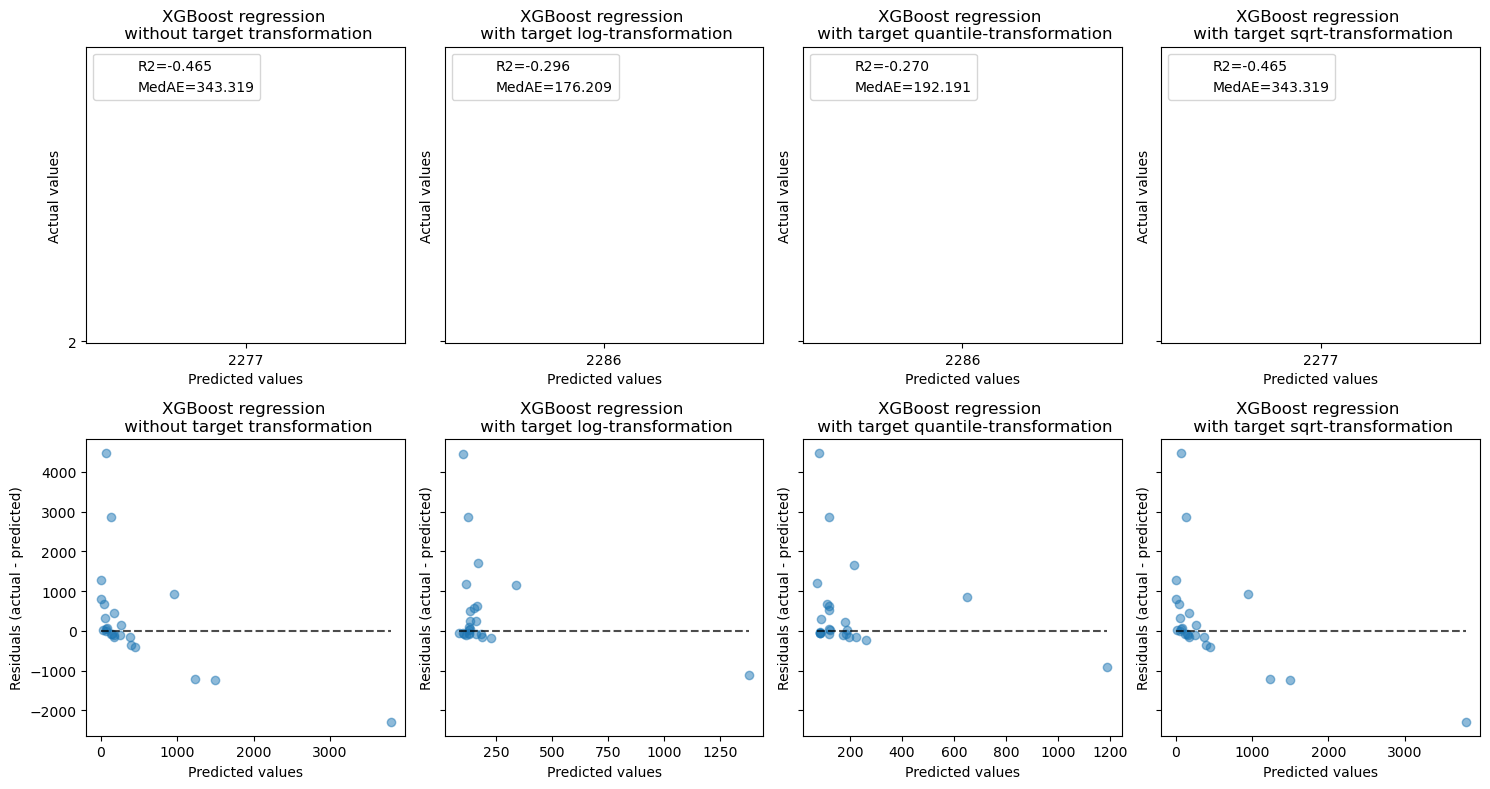

In [ ]:
#y_pred_log_train = model_log.predict(X_train)
y_pred = model.predict(X_test)
y_pred_log = model_log.predict(X_test)
y_pred_quantile = model_quantile.predict(X_test)
#y_pred_boxcox = model_boxcox.predict(X_test)
y_pred_sqrt = model_sqrt.predict(X_test)


f, (ax0, ax1) = plt.subplots( 2, 4,  sharey="row", figsize=(15, 8)) # 

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="actual_vs_predicted",
    ax=ax0[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="actual_vs_predicted",
#     ax=ax0[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="actual_vs_predicted",
    ax=ax0[3],
    scatter_kwargs={"alpha": 0.5},
)
ax0[0].set_title("XGBoost regression \n without target transformation")
ax0[1].set_title("XGBoost regression \n with target log-transformation")
ax0[2].set_title("XGBoost regression \n with target quantile-transformation")
ax0[3].set_title("XGBoost regression \n with target sqrt-transformation")
#ax0[3].set_title("XGBoost regression \n with target boxcox-transformation")

ax0[0].set_ylim(0, 300)


# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_sqrt]):
#for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_boxcox]):
    for name, score in e.compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="residual_vs_predicted",
    ax=ax1[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="residual_vs_predicted",
#     ax=ax1[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="residual_vs_predicted",
    ax=ax1[3],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("XGBoost regression \n without target transformation")
ax1[1].set_title("XGBoost regression \n with target log-transformation")
ax1[2].set_title("XGBoost regression \n with target quantile-transformation")
#ax1[3].set_title("XGBoost regression \n with target boxcox-transformation")
ax1[3].set_title("XGBoost regression \n with target sqrt-transformation")

#ax1[0].set_ylim(0,200)


#f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()


## reload models


#model_eval = pickle.load(open(f"./models_trained/xgboost_{target}_{pipe_name}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

## left overs

### outdated -Feature importance
Have the same feature importance method across all applied ML models


In [ ]:

# df_importance_package = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : model.feature_importances_,
#      }) 
# df_importance_package.sort_values("importances", ascending=False)[:10]

In [ ]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
# #    "importances" : np.abs(result[0]),
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=True)  # get most important features to the top
# df_importance.tail(18)

### plot feature importance


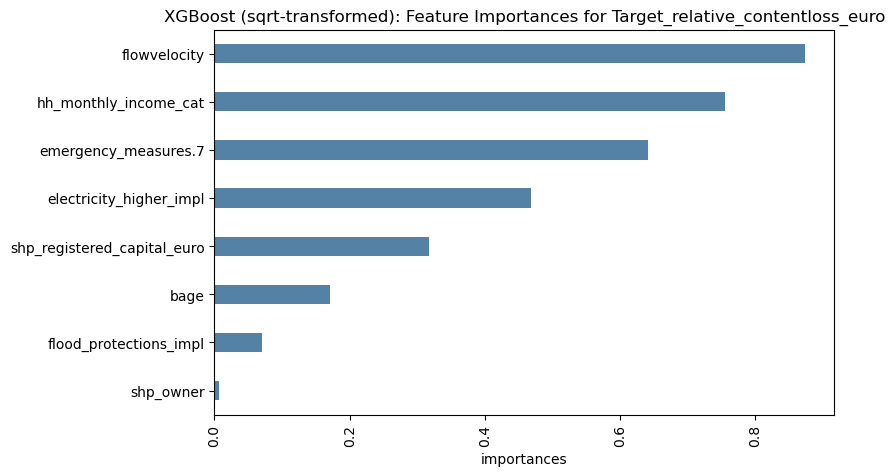

In [ ]:
# # reload evalation set
# eval_set = eval_set_list[0]#[pipe_name]


# importances = e.permutation_feature_importance(model_sqrt, 
# #importances = e.permutation_feature_importance(model, 
#                                                X_test,
#                                                y_test,
#                                                #eval_set.drop(target, axis=1), 
#                                                #eval_set[target], 
#                                                repeats=5, seed=seed
#                                                )

# ## feature importance scores
# df_importance = pd.DataFrame({
#     "name" : X.columns.to_list(),
#     "importances" : importances[0],
#      }) 

# # drop features which dont reduce the loss
# df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
# df_importance = df_importance.sort_values("importances", ascending=False)


# #fig, ax = plt.subplots(figsize=(12,5))
# plt.figure(figsize=(8, 5))
# #plt.barh(df_importance.name, df_importance.importances)
# #plt.barh(df_importance.name[-18:], df_importance.importances[-18:])

# sns.barplot(
#     data=df_importance, 
#     x="importances", y="name",
#     width=0.4,
#     color='steelblue',
#     #errorbar="sd",
#     errorbar=("pi", 50), 
#     capsize=.1, errcolor=".5",
#     linewidth=3, #edgecolor=".3", #facecolor=(0,0,0,0),
# )
# plt.ylabel("")
# plt.xticks(
#     rotation = 90
#     )
# plt.title(f"XGBoost (sqrt-transformed): Feature Importances for {target}")
# plt.show()

# ## save importnace scores  and figure
# #filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
# #if not glob(filepath):
# #    df_importance.to_csv(filename, index = False)


# #plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')





### partial dependencies

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_title("Decision Tree")
# tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_xgb"], pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=ax)
#tree_disp = PartialDependenceDisplay.from_estimator(model, pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=ax)

tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_en"], pd.DataFrame(X, columns=X.columns), ["shp_employees"])
mlp_disp = PartialDependenceDisplay.from_estimator(
    models_trained["trained_xgb"], pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=tree_disp.axes_, line_kw={"color": "red"}
)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# tree_disp.plot(ax=[ax1, ax2], line_kw={"label": "Decision Tree"})
# tree_disp.plot(
#     ax=[ax1, ax2], line_kw={"label": "Multi-layer Perceptron", "color": "red"}
# )
# ax1.legend()
# ax2.legend()

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py # code example

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(df_candidates).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=df_candidates.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax1.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax1.set_xticks(dendro_idx)
# ax1.set_yticks(dendro_idx)
# ax1.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax1.set_yticklabels(dendro["ivl"])
# _ = fig.tight_layout()


In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

# cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# X_train_sel = X_train[:, selected_features]
# X_test_sel = X_test[:, selected_features]



In [ ]:
# closs hyperapram , no model__early_stopping_rounds, repeatedcv wit h10 folds
## best train R2: ntree=30, max_depth =1, no furhter params

# learning_rate = [ 0.00001, 0.0001, 0.001, 0.1, 0.2]#, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9] # store outside, for plotting
# n_estimators = [ 50, 100, 200, 300, 500, 800]

# param_space = {'model__n_estimators': n_estimators,
#     #'model__n_estimators': [ 3, 5, 10, 20], # get only low train scores with this
#               'model__max_depth': [1, 2, 3, 5, 7, 8, 10, 15],
#               #'model__max_leaves': [0, 3, 5],
#              # 'model__colsample_bytree': [ 0.3, 0.5, 0.7, 1.0 ], # Percentage of columns to be randomly samples for each tree
#              # 'model__colsample_bynode': [ 0.3, 0.5, 0.7, 1.0], # nbr of feautres for each split point
#              # 'model__eta': learning_rate,  # == eta
#             #   'model__gamma': [0.2, 0.3, 0.5, 0.8, 1, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
#               'model__subsample': [0.0, 0.2, 0.5, 0.6, 0.8, 0.9],  # define subsample of train st prior to growing trees, prevent overfitting
#             #  'model__reg_alpha': [0.5, 1.0, 2.0, 4.0, 5.0, 6.0 ,7.0],   # Lasso Regularization term on weights , higher values = more consrvative 
#             #  'model__reg_lambda': [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
#             #   'model__min_child_weight': [0, 1, 2, 3, 4,],
#             #   "model__max_delta_step":  [0, 3, 5, 6, 7],           # for LogisticReg good to solve imbalance 
#           #   'model__objective': [None, 'reg:absoluteerror'],#'multi:softprob,'reg:squarederror','reg:models_trained'],
#           #  # 'model__tree_method': ["hist", "gpu_hist"],
#           #   'model__booster': [None, "gblinear", "gbtree"],
#             "model__validate_parameters":[True],
#               }

# # 'model__scale_pos_weight': [0.0, 0.3, 0.5, 0.7, 0.9, 1.0],  # only  for clasifcation: handle imbalance, ratio between negative and positive examples

# # Objective candidate: multi:softmax
# # Objective candidate: multi:softprob
# # Objective candidate: reg:squarederror
# # Objective candidate: reg:squaredlogerror
# # Objective candidate: reg:logistic
# ## Objective candidate: reg:linear
# # Objective candidate: reg:pseudohubererror
# # Objective candidate: reg:gamma
# # Objective candidate: reg:absoluteerror

# ## DOC: https://xgboost.readthedocs.io/en/stable/parameter.html
